In [2]:
import pandas as pd
import numpy as np
#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import mean_squared_error
import os
# os.chdir("/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/CMaps/")
#for deep learning
import tensorflow.keras
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks

2023-11-01 08:38:44.393786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
cwd = os.getcwd()
train_data = pd.read_csv(os.path.join(cwd,"train_FD001.txt"), sep="\s+", header=None)
test_data = pd.read_csv(os.path.join(cwd,"test_FD001.txt"), sep="\s+", header=None)
true_rul = pd.read_csv(os.path.join(cwd,"RUL_FD001.txt"), sep="\s+", header=None)
print(train_data.shape)
print(test_data.shape)
print(true_rul.shape)

(20631, 26)
(13096, 26)
(100, 1)


In [73]:
def process_input_data_with_targets(input_data, target_data=None, window_length=1, shift=1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.    
        Number of batches = np.floor((len(input_data) - window_length)/shift) + 1    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.        
    """
    num_batches = int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats=num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets
        

def process_targets(data_length, early_rul=None):
    """ 
    Takes datalength and earlyrul as input and 
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_laaength-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape=(early_rul_duration,)), np.arange(early_rul-1, -1, -1))
        
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows=1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine               [-required_len:, :], target_data=None, window_length=window_length, shift=shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :], target_data=None, window_length=window_length, shift=shift)
        return batched_test_data_for_an_engine, num_test_windows

In [74]:
cwd = os.getcwd()
train_data = pd.read_csv(os.path.join(cwd,"train_FD001.txt"), sep="\s+", header=None)
test_data = pd.read_csv(os.path.join(cwd,"test_FD001.txt"), sep="\s+", header=None)
true_rul = pd.read_csv(os.path.join(cwd,"RUL_FD001.txt"), sep="\s+", header=None)
print(train_data.shape)
print(test_data.shape)
print(true_rul.shape)

(20631, 26)
(13096, 26)
(100, 1)


In [75]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [76]:
# 0-id
# 1-cycle
# 2-setting1
# 3-setting2 
# 4-setting3
# 5-s1
# 6-s2
# 7-s3
# 8-s4
# 9-s5
# 10-s6
# 11-s7
# 12-s8
# 13-s9
# 14-s10
# 15-s11
# 16-s12
# 17-s13
# 18-s14
# 19-s15
# 20-s16
# 21-s17
# 22-s18
# 23-s19


In [77]:
# - drop the columns 
# [0,1,2,3,4,5,9,10,14,20,22,23]

# id,cycle,setting1,setting2,setting3,s1,s5,s6,s10,s16,s18,s19


In [78]:
window_length = 30
shift = 1
early_rul = 125            
processed_train_data = []
processed_train_targets = []
# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.

num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.
# Process trianing data

for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")        
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length=window_length, shift=shift)    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)
processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length=window_length, shift=shift,
                                                             num_test_windows=num_test_windows)    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)
processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values
# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]
print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)


In [79]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size=0.2,
                                                                                                            random_state=83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 14)
Processed validation data shape:  (3547, 30, 14)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


In [80]:
def create_compiled_model():
    model = Sequential([
        LSTM(128, input_shape = (window_length, 14), return_sequences=True, activation="tanh"),
        LSTM(64, activation="tanh", return_sequences = True),
        LSTM(32, activation="tanh"),
        Dense(96, activation="relu"),
        Dense(128, activation="relu"),
        Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [81]:
#use a learning rate scheduler that will decrease the learning rate after 5 epochs
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001

In [82]:
callback = callbacks.LearningRateScheduler(scheduler, verbose=1)
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs=10,
                    validation_data=(processed_val_data, processed_val_targets),
                    callbacks=callback, batch_size=128, verbose=2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
111/111 - 23s - loss: 3966.5081 - val_loss: 1766.6978 - lr: 0.0010 - 23s/epoch - 209ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
111/111 - 14s - loss: 1744.7592 - val_loss: 1761.2766 - lr: 0.0010 - 14s/epoch - 123ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
111/111 - 14s - loss: 1744.0576 - val_loss: 1761.1724 - lr: 0.0010 - 14s/epoch - 127ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
111/111 - 14s - loss: 1744.5961 - val_loss: 1741.8318 - lr: 0.0010 - 14s/epoch - 125ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
111/111 - 14s - loss: 712.3620 - val_loss: 293.2589 - lr: 0.0010 - 14s/epoch - 128ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/10
111/111 - 14s - loss: 241.3487 - val_loss: 234.3252 - lr: 1.0000e-04 - 14s/epoch - 128ms/st

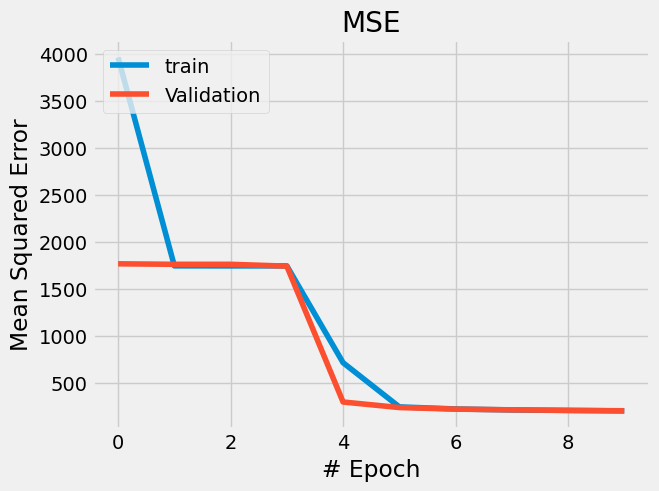

In [83]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('# Epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [84]:
scores = model.evaluate(processed_train_data, processed_train_targets, verbose=1, batch_size=200)
print('MSE: {}'.format(scores))

71/71 [==============================] - 6s 78ms/step - loss: 196.1883
MSE: 196.18832397460938


In [85]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

16/16 [==============================] - 1s 19ms/step
RMSE:  15.651931657110405


In [86]:
mean_squared_error(true_rul, mean_pred_for_each_engine)


244.98296459885486

In [89]:
rul_pred[0]

110.65347

In [88]:
true_rul

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20])